<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-alignment-data" data-toc-modified-id="Load-alignment-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load alignment data</a></span></li><li><span><a href="#Copy-filtered-slide-images-to-new-folder" data-toc-modified-id="Copy-filtered-slide-images-to-new-folder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Copy filtered-slide images to new folder</a></span></li><li><span><a href="#Using-docarray-to-construct" data-toc-modified-id="Using-docarray-to-construct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using <code>docarray</code> to construct</a></span></li><li><span><a href="#Baseline-models-construction" data-toc-modified-id="Baseline-models-construction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline models construction</a></span></li><li><span><a href="#Training-set-and-Testing-set-spilt" data-toc-modified-id="Training-set-and-Testing-set-spilt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training set and Testing set spilt</a></span></li><li><span><a href="#Model-Implementation(Baseline)" data-toc-modified-id="Model-Implementation(Baseline)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Implementation(Baseline)</a></span><ul class="toc-item"><li><span><a href="#Textual-approach" data-toc-modified-id="Textual-approach-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Textual approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Textual)" data-toc-modified-id="Naive-Bayes-(Textual)-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Naive Bayes (Textual)</a></span></li><li><span><a href="#Evaluation-Textual-Results" data-toc-modified-id="Evaluation-Textual-Results-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Evaluation Textual Results</a></span></li></ul></li><li><span><a href="#Visual-approach" data-toc-modified-id="Visual-approach-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visual approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Visual)" data-toc-modified-id="Naive-Bayes-(Visual)-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Naive Bayes (Visual)</a></span></li><li><span><a href="#Evaluation-Visual-Results" data-toc-modified-id="Evaluation-Visual-Results-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Evaluation Visual Results</a></span></li></ul></li><li><span><a href="#Multi-modal-approach" data-toc-modified-id="Multi-modal-approach-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Multi-modal approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Multi-modal)" data-toc-modified-id="Naive-Bayes-(Multi-modal)-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Naive Bayes (Multi-modal)</a></span></li><li><span><a href="#Evaluation-Multi-modal-Results" data-toc-modified-id="Evaluation-Multi-modal-Results-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Evaluation Multi-modal Results</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from typing import List
from docarray import dataclass, Document, DocumentArray
from docarray.typing import Image, Text, JSON, URI
import ast
import pandas as pd
import os
import numpy as np
import platform
import shutil

is_windows = platform.system().lower() == 'windows'
if is_windows:
    source_dir = "C:\\Users\\Kun\\Desktop" 
else:
    source_dir = "/Users/kun-lin/Desktop"
source_dir = os.path.join(source_dir, f"Angebot")
dest_dir = "output"
PPTtoImg_dir = os.path.join(dest_dir, f"PPTtoImg")
fWordImg_dir = os.path.join(dest_dir, f"FewWordImg")
ct_fWordImg_dir = os.path.join(fWordImg_dir, f"CT_FewWordImg")
topshapetype_dir = os.path.join(dest_dir, f"TopShapeTypeImg")
labels_dir = os.path.join(dest_dir, f"LABELS")
checkpoint_path = os.path.join(dest_dir, f"checkpoints")

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
if not os.path.exists(PPTtoImg_dir):
    os.makedirs(PPTtoImg_dir)
if not os.path.exists(fWordImg_dir):
    os.makedirs(fWordImg_dir)
if not os.path.exists(ct_fWordImg_dir):
    os.makedirs(ct_fWordImg_dir)  
if not os.path.exists(topshapetype_dir):
    os.makedirs(topshapetype_dir)
if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Load alignment data

In [2]:

def convert_to_list(data):
    return ast.literal_eval(data)
# Since it take too much time on traversal ppt files, Easily to import the dataframe from the csv file
df_da = pd.read_csv('alignment_pptx_list.csv', converters={'shape_type': convert_to_list})
# for Mac OS
if not is_windows:
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('C\\Users\\Kun\\Desktop\\Angebot', source_dir))
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('\\', '/'))

df_da = df_da[~df_da['contents'].isnull()]
df_da.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26468 entries, 0 to 26467
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   26468 non-null  object
 1   page_num    26468 non-null  int64 
 2   shape_type  26468 non-null  object
 3   contents    26468 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [3]:
# filter out less than 4 words
df_da['word_count'] = df_da['contents'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_few_words = df_da[~(df_da['word_count'] <= 4)]
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [4]:
df_json = pd.read_json(os.path.join(labels_dir, "3355_annotations.json"))
df_json['choice'].value_counts()

Others                         547
Working Package Examples       519
Working Package Description    449
Reference Details              309
Offer Title                    266
Consultant Profile             242
Project Calculation            227
Initial & Target Situation     182
Working Package Overview       179
Reference Overview             159
Competencies                   137
Target Situation                77
Initial Situation               62
Name: choice, dtype: int64

In [5]:
count = 13
for idx, row in df_json[df_json['image'].str.contains('22348')].iterrows():
  new_image_name = df_json.loc[idx, 'image'].split('.')[0] + '_' + str(count) + '.PNG'
  print(idx, new_image_name)
  df_json.at[idx, 'image'] = new_image_name
  count += 1

137 /data/upload/3/33344dac-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_iHJAu6y_13.PNG
1434 /data/upload/3/30b5074c-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_EVP8fho_14.PNG


In [6]:
df_json['page_num'] = df_json['image'].apply(lambda x: int(x.split('.')[0].split('_')[-1]) if x.split('.')[0].split('_')[-1].isdigit() else 0)
df_json['image'] = df_json['image'].apply(lambda x: x.split('.')[0].split('-')[1])

In [7]:
df_json['image'][0]

'9578_9578_PPM_Rollout_project_outline_9'

In [8]:
# be aware of path difference between Windows and Mac OS
df_few_words['label'] = ''

for i in range(len(df_json)):
    item = df_json.iloc[i]
    f_name = item['image']
    page = int(df_json.at[i, 'page_num'])
    ktr = f_name.split('_')[0]
    # some issues that it should modify manually
    if (ktr == '22348' and page == 13):
      df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)), 'label'] = 'Initial Situation'
      continue
    elif (ktr == '22348' and page == 14):
      df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)), 'label'] = 'Target Situation'
      continue

    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = item['choice']



C:\Users\Kun\AppData\Local\Temp\ipykernel_24516\3989440777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_few_words['label'] = ''


In [9]:
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
 5   label       23148 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [10]:
df_few_words[df_few_words['label'].isna()]

,file_name,page_num,shape_type,contents,word_count,label


In [11]:
df_few_words['label'].value_counts()

                               19741
Others                           547
Working Package Examples         522
Working Package Description      450
Reference Details                316
Offer Title                      266
Consultant Profile               242
Project Calculation              228
Initial & Target Situation       184
Working Package Overview         181
Reference Overview               160
Competencies                     137
Target Situation                 112
Initial Situation                 62
Name: label, dtype: int64

In [12]:
import re
df_no_label = df_few_words[df_few_words['label']=='']
df_filter=df_no_label[df_no_label['contents'].str.contains('Starting Point|Objective Target|Initial Situation|Target Situation|Zielsetzung|Ausgangssituation|Ausgangssituation & Zielsetzung|Ausgangssituation und Zielsetzung|Starting Point and Objective|Starting Point & Objective', 
                                                 flags=re.IGNORECASE)]
df_filter['file_name'].apply(lambda x: x.split('\\')[5]).unique()

array(['13179', '13181', '13202', '13204', '13225', '13226', '13229',
       '13242', '13243', '13251', '13253', '20039', '20044', '20055',
       '20057', '20062', '20063', '20065', '20066', '20074', '20076',
       '20083', '20084', '20085', '20086', '20087', '20088', '20094',
       '20095', '20101', '20104', '20105', '20106', '20107', '20112',
       '20116', '20117', '20119', '20120', '20121', '20122', '20123',
       '20124', '20125', '20127', '20128', '20129', '20132', '20133',
       '20138', '20140', '20142', '20143', '20144', '20149', '20150',
       '20151', '20152', '20153', '20155', '20165', '20166', '20194',
       '20195', '20196', '20200', '20203', '20204', '20211', '20212',
       '20216', '20218', '20221', '20229', '20231', '20236', '20244',
       '20251', '20252', '20254', '20256', '20259', '20260', '20261',
       '20263', '20269', '20272', '20273', '20279', '20284', '20301',
       '20302', '20304', '20305', '20306', '20309', '20312', '20334',
       '20350', '203

In [13]:
for i in df_filter['file_name'].apply(lambda x: x.split('\\')[5]).unique():
    print(i)

13179
13181
13202
13204
13225
13226
13229
13242
13243
13251
13253
20039
20044
20055
20057
20062
20063
20065
20066
20074
20076
20083
20084
20085
20086
20087
20088
20094
20095
20101
20104
20105
20106
20107
20112
20116
20117
20119
20120
20121
20122
20123
20124
20125
20127
20128
20129
20132
20133
20138
20140
20142
20143
20144
20149
20150
20151
20152
20153
20155
20165
20166
20194
20195
20196
20200
20203
20204
20211
20212
20216
20218
20221
20229
20231
20236
20244
20251
20252
20254
20256
20259
20260
20261
20263
20269
20272
20273
20279
20284
20301
20302
20304
20305
20306
20309
20312
20334
20350
20353
20354
20355
20356
20367
20370
20373
20379
20390
20395
20398
20400
20406
20414
20416
20417
20420
20422
20424
20428
20433
20436
20439
20441
20444
20445
20451
20452
20453
20455
20458
20460
20469
20474
20476
20477
20487
20489
20490
20491
20499
20500
20501
20502
20507
20509
20519
20529
20531
20533
20537
20538
20558
20559
20562
20566
20568
20569
20570
20571
20577
20587
20596
20598
20602
20604
20607
2060

# Copy filtered-slide images to new folder 

In [ ]:
def delete_png_files(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.lower().endswith(".PNG"):
            os.remove(filepath)

In [7]:
# copy filtered-data to new folder(FewWordImg)
delete_png_files(fWordImg_dir)
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(PPTtoImg_dir)  # image output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        
        # from PPTtoImg to FewWordImg
        shutil.copy(imgpath, os.path.join(os.getcwd(), fWordImg_dir))

> This process is to ignore **Chapter Covers** images so that we make them labeling easier

# Using `docarray` to construct

In [14]:
@dataclass
class MySlide:
    Content: Text #chunk
    ImgPath: Image #chunk
    ShapeType: List[str] #tag
    PageNum: int #tag
    Label: str #tag

@dataclass
class MyPPT:
    FileName: Text
    Slide: List[MySlide]

group_slide = DocumentArray()
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(fWordImg_dir)  # filter-images output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        # imgpath = os.path.join(image_dir_path, )
        
        m = MySlide(
                    Content = row['contents'],
                    ImgPath = imgpath,
                    ShapeType = row['shape_type'],
                    PageNum = row['page_num'],
                    Label = row['label']
                )
        
        group_slide.append(Document(m))
            
docPPT = Document(MyPPT(FileName = path, Slide = group_slide))

In [15]:
docPPT_1620 = Document(MyPPT(FileName=docPPT.FileName, Slide=[d for d in docPPT.Slide if d.tags['Label'] != ''and d.tags['Label'] != 'Others']))

# Baseline models construction

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, train_test_split, KFold

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# This function will print the metrcis for diffeent model
def print_model_report(y_test, prediction, ML_modelName):
    print("Model report for: "+ ML_modelName + "\n")
    print(classification_report(y_test, prediction, digits=4, target_names=['Competencies[0]', 
                                                                            'Consultant Profile[1]', 
                                                                            'Initial & Target Situation[2]', 
                                                                            'Initial Situation[3]', 
                                                                            'Offer Title[4]', 
                                                                            'Project Calculation[5]', 
                                                                            'Reference Details[6]', 
                                                                            'Reference Overview[7]',
                                                                            'Target Situation[8]',
                                                                            'Working Package Description[9]',
                                                                            'Working Package Examples[10]',
                                                                            'Working Package Overview[11]']))
    # print(classification_report(y_test, prediction, digits=4,))
    
# Show confusion matrix plot
def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):
    cm = confusion_matrix(y_test, prediction)
    
    ax = sns.heatmap(cm, 
              annot=True, 
              annot_kws={'size':18,'weight':'normal'},
              fmt='.20g', 
              cmap=cmap, 
              cbar_kws={'shrink':1},
              linewidths=2)
    
    plt.title("Confusion Matrix for: " + ML_modelName)
    plt.ylabel("Actual Label")
    plt.xlabel("Predict Label")
    cbar = ax.collections[0].colorbar
    plt.show()
    
    
def stratifiedVD(X_train, y_train, ex_model):
    #StratifiedKFold is a variation of KFold
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_train, y_train)
    score_list = []
    for k, (train, test) in enumerate(SKF):

        print(train.shape, test.shape)
        # instantiate the model
        ex_model.fit(X_train.iloc[train], y_train.iloc[train])
        # calculate the score each fold
        score = ex_model.score(X_train.iloc[test], y_train.iloc[test])
        score_list.append(score)

        print(f'Fold: {k+1:2d}, Class dist.: {np.bincount(y_train.iloc[train])}, Acc: {score:.3f}')    

    print(f'\nCV accuracy: {np.mean(score_list):.3f} +/- {np.std(score_list):.3f}')
    

def evaluate_model(X, y, pipline):
    # instantiate the model
    # RSKF = RepeatedStratifiedKFold(n_splits=10, random_state=42, n_repeats=3)
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(pipline, X, y, cv= SKF, scoring='accuracy', n_jobs=-1)
    return scores


def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        # roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average= average , multi_class="ovr")

        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

# Training set and Testing set spilt

In [18]:
dict_augment = {'ori':docPPT.Slide, 'slide_1620':docPPT_1620.Slide}

In [19]:
# given textual or visual information as X variable and the category as y variable
def get_X_y_set(dict_aug):
    dict_ = dict()
    for str, da in dict_aug.items():
        X_text = da['@.[Content]'].to_dataframe().text
        X_shape = pd.Series([slide.tags['ShapeType'] for slide in da])
        y = pd.Series([slide.tags['Label'] for slide in da])
        print(str, X_text.shape, X_shape.shape, y.shape)
        dict_[str] = pd.DataFrame({'X_text': X_text, 'X_shape': X_shape, 'y': y})
        
    return dict_

dict_X_y = get_X_y_set(dict_augment)

ori (23148,) (23148,) (23148,)
slide_1620 (2860,) (2860,) (2860,)


In [20]:
dict_X_y['slide_1620']

,X_text,X_shape,y
0,iCert 20 Change Management Design Sprint Sup...,"[PICTURE, FREEFORM, TEXT_BOX]",Offer Title
1,Thematic Focus Transformation change managemen...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, TEXT_...",Consultant Profile
2,Secure Life Cycle Management LCM Process Enclo...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, TEXT_BOX, E...",Offer Title
3,Hamilton provides intelligent ventilation prod...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEF...",Initial & Target Situation
4,Impulse and Process Review of todays LCM proce...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEFORM, G...",Working Package Description
...,...,...,...
2855,6079 Heinrich Meintrup Executive Vice Presiden...,"[TEXT_BOX, AUTO_SHAPE]",Reference Details
2856,9561 Analysis and critical review of the curre...,"[TEXT_BOX, AUTO_SHAPE]",Reference Details
2857,PPMRail project KnorrBremse is consolidating a...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEF...",Initial & Target Situation
2858,Evaluate the scope of the implemented function...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEFORM, G...",Working Package Overview


In [21]:
keys = 'slide_1620'
dict_X_y[keys]['y'].value_counts()

Working Package Examples       522
Working Package Description    450
Reference Details              316
Offer Title                    266
Consultant Profile             242
Project Calculation            228
Initial & Target Situation     184
Working Package Overview       181
Reference Overview             160
Competencies                   137
Target Situation               112
Initial Situation               62
Name: y, dtype: int64

In [22]:
df_features = pd.DataFrame.from_dict(dict_X_y[keys])

labelencoder = LabelEncoder()
# df_features['y_encoded'] = labelencoder.fit_transform(dict_X_y[keys]['y'])
df_features['y_encoded'] = labelencoder.fit_transform(df_features['y'])
features = [c for c in df_features.columns.values if c not in ['y', 'y_encoded']]
features

['X_text', 'X_shape']

In [23]:
# Train and Test data splits
X_train, X_test, y_train, y_test = train_test_split(df_features[features], df_features['y_encoded'], test_size=0.2,
                                                    stratify=df_features['y_encoded'], random_state=42, shuffle=True)

In [24]:
df_features['y_encoded'].value_counts()

10    522
9     450
6     316
4     266
1     242
5     228
2     184
11    181
7     160
0     137
8     112
3      62
Name: y_encoded, dtype: int64

# Model Implementation(Baseline)

## Textual approach

In [25]:
# bag of words for chi square
# vectorize_cal = CountVectorizer(max_df= 0.85, min_df=2)
vectorize_cal = CountVectorizer()
sparse_matrix = vectorize_cal.fit_transform(X_train['X_text'], y_train)

df_bow=pd.DataFrame(sparse_matrix.toarray(), columns=vectorize_cal.get_feature_names_out())
# df_bow
k_best_cal = SelectKBest(score_func = chi2, k = 2500)
best_matrix = k_best_cal.fit(df_bow, y_train)

cols = best_matrix.get_support(indices=True)
features_df_new = df_bow.iloc[:,cols]
features_df_new.index = X_train['X_text'].index
features_df_new

,02,03,04,05,100,1000,1020,11311,12,12281,...,über,übergeordnetes,übergreifendes,übernommen,überschrift,übersicht,übertragung,überwachung,überweisung,überzeugten
1920,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1689,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Naive Bayes (Textual)

In [26]:
pipeline_nb_t = Pipeline([('vect', CountVectorizer()),
                          ('chi', SelectKBest(score_func = chi2, k = 4500)),
                          ('tfidf', TfidfTransformer()),
                          ('model', MultinomialNB())])


model_nb_t = pipeline_nb_t.fit(X_train['X_text'], y_train)


### Evaluation Textual Results

In [27]:
stratifiedVD(X_train['X_text'], y_train, model_nb_t)

(2059,) (229,)
Fold:  1, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.677
(2059,) (229,)
Fold:  2, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.721
(2059,) (229,)
Fold:  3, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.590
(2059,) (229,)
Fold:  4, Class dist.: [ 99 174 132  45 192 164 228 115  81 324 375 130], Acc: 0.712
(2059,) (229,)
Fold:  5, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.694
(2059,) (229,)
Fold:  6, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.703
(2059,) (229,)
Fold:  7, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.681
(2059,) (229,)
Fold:  8, Class dist.: [ 99 175 132  44 192 163 227 116  81 324 376 130], Acc: 0.672
(2060,) (228,)
Fold:  9, Class dist.: [ 99 175 132  44 192 163 227 116  81 324 376 131], Acc: 0.671
(2060,) (228,)
Fold: 10, Class dist.: [ 99 175 132  44 192 164 227 115  81 324 376 131], Acc: 0.711


In [28]:
pred_nb_t = model_nb_t.predict(X_test['X_text'])

Model report for: Naive Bayes (Textual)

                                precision    recall  f1-score   support

               Competencies[0]     0.9474    0.6667    0.7826        27
         Consultant Profile[1]     0.8704    0.9792    0.9216        48
 Initial & Target Situation[2]     0.8182    0.2432    0.3750        37
          Initial Situation[3]     1.0000    0.0769    0.1429        13
                Offer Title[4]     0.9623    0.9623    0.9623        53
        Project Calculation[5]     1.0000    0.9348    0.9663        46
          Reference Details[6]     0.8367    0.6508    0.7321        63
         Reference Overview[7]     0.8889    0.2500    0.3902        32
           Target Situation[8]     0.0000    0.0000    0.0000        22
Working Package Description[9]     0.5430    0.9111    0.6805        90
  Working Package Examples[10]     0.5278    0.9048    0.6667       105
  Working Package Overview[11]     1.0000    0.0556    0.1053        36

                     

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


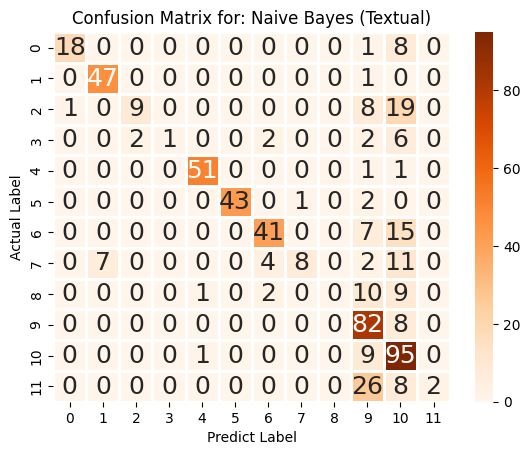

{0: 0.8324159021406727,
 1: 0.9829039440203561,
 2: 0.6197524627431169,
 3: 0.5384615384615384,
 4: 0.979205293198095,
 5: 0.9673913043478262,
 6: 0.8175382792278666,
 7: 0.624074074074074,
 8: 0.5,
 9: 0.8839787920700783,
 10: 0.8613745283980828,
 11: 0.5277777777777778}

In [29]:
print_model_report(y_test, pred_nb_t, "Naive Bayes (Textual)")
plot_confusion_matrix(y_test, pred_nb_t, "Naive Bayes (Textual)", plt.cm.Oranges)
roc_auc_score_multiclass(y_test, pred_nb_t)

## Visual approach

In [30]:
types = ['AUTO_SHAPE', 'CALLOUT', 'CANVAS', 'CHART',
        'COMMENT', 'DIAGRAM', 'EMBEDDED_OLE_OBJECT', 'FORM_CONTROL',
        'FREEFORM', 'GROUP', 'IGX_GRAPHIC', 'INK', 'INK_COMMENT',
        'LINE', 'LINKED_OLE_OBJECT', 'LINKED_PICTURE', 'MEDIA',
        'OLE_CONTROL_OBJECT', 'PICTURE', 'PLACEHOLDER', 'SCRIPT_ANCHOR',
        'TABLE', 'TEXT_BOX', 'TEXT_EFFECT', 'WEB_VIDEO', 'MIXED']

mlb = MultiLabelBinarizer(classes=types)
onehot = mlb.fit_transform(X_train['X_shape'])
df_shapes = pd.DataFrame(onehot, columns=mlb.classes_, index=X_train['X_shape'].index)
df_shapes

,AUTO_SHAPE,CALLOUT,CANVAS,CHART,COMMENT,DIAGRAM,EMBEDDED_OLE_OBJECT,FORM_CONTROL,FREEFORM,GROUP,...,MEDIA,OLE_CONTROL_OBJECT,PICTURE,PLACEHOLDER,SCRIPT_ANCHOR,TABLE,TEXT_BOX,TEXT_EFFECT,WEB_VIDEO,MIXED
1920,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,0,0,0,0
142,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
49,1,0,0,0,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,0
479,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1689,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
166,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,0,0,0,0
1148,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
944,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,0,0,0,0


### Naive Bayes (Visual)

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.mlb = MultiLabelBinarizer(classes=classes)
    
    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, X):
        return self.mlb.transform(X)

pipeline_nb_v = Pipeline([
    ('mlb_transformer', MultiLabelBinarizerTransformer(classes=types)),
    ('model', MultinomialNB())
])

model_nb_v = pipeline_nb_v.fit(X_train['X_shape'], y_train)

### Evaluation Visual Results

In [32]:
stratifiedVD(X_train['X_shape'], y_train, model_nb_v)

(2059,) (229,)
Fold:  1, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.546
(2059,) (229,)
Fold:  2, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.563
(2059,) (229,)
Fold:  3, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.537
(2059,) (229,)
Fold:  4, Class dist.: [ 99 174 132  45 192 164 228 115  81 324 375 130], Acc: 0.590
(2059,) (229,)
Fold:  5, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.555
(2059,) (229,)
Fold:  6, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.576
(2059,) (229,)
Fold:  7, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.572
(2059,) (229,)
Fold:  8, Class dist.: [ 99 175 132  44 192 163 227 116  81 324 376 130], Acc: 0.568
(2060,) (228,)
Fold:  9, Class dist.: [ 99 175 132  44 192 163 227 116  81 324 376 131], Acc: 0.579
(2060,) (228,)
Fold: 10, Class dist.: [ 99 175 132  44 192 164 227 115  81 324 376 131], Acc: 0.579


In [33]:
pred_nb_v = model_nb_v.predict(X_test['X_shape'])

Model report for: Naive Bayes (Visual)

                                precision    recall  f1-score   support

               Competencies[0]     0.0000    0.0000    0.0000        27
         Consultant Profile[1]     0.9756    0.8333    0.8989        48
 Initial & Target Situation[2]     0.0000    0.0000    0.0000        37
          Initial Situation[3]     0.0000    0.0000    0.0000        13
                Offer Title[4]     0.8421    0.9057    0.8727        53
        Project Calculation[5]     0.9487    0.8043    0.8706        46
          Reference Details[6]     0.8889    0.8889    0.8889        63
         Reference Overview[7]     0.0000    0.0000    0.0000        32
           Target Situation[8]     0.0000    0.0000    0.0000        22
Working Package Description[9]     0.5625    0.9000    0.6923        90
  Working Package Examples[10]     0.3904    0.8476    0.5345       105
  Working Package Overview[11]     0.0000    0.0000    0.0000        36

                      

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


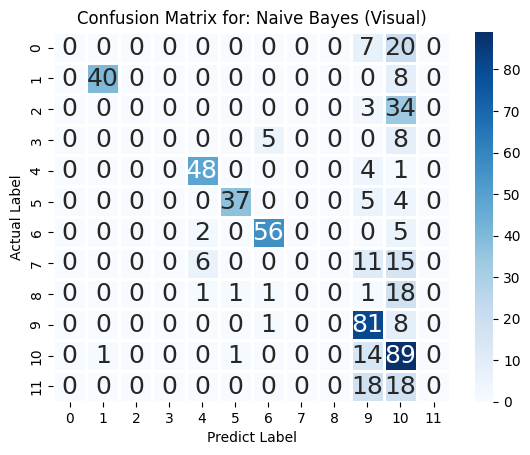

{0: 0.5,
 1: 0.9157124681933844,
 2: 0.5,
 3: 0.5,
 4: 0.9441596684480313,
 5: 0.9002727723590676,
 6: 0.9375682165466054,
 7: 0.5,
 8: 0.5,
 9: 0.8846473029045643,
 10: 0.7749872540022433,
 11: 0.5}

In [34]:
print_model_report(y_test, pred_nb_v, "Naive Bayes (Visual)")
plot_confusion_matrix(y_test, pred_nb_v, "Naive Bayes (Visual)", plt.cm.Blues)
roc_auc_score_multiclass(y_test, pred_nb_v)

## Multi-modal approach

### Naive Bayes (Multi-modal)

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin


class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class ShapeSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on shape columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.mlb = MultiLabelBinarizer(classes=classes)
    
    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, X):
        return self.mlb.transform(X)    

types = ['AUTO_SHAPE', 'CALLOUT', 'CANVAS', 'CHART',
        'COMMENT', 'DIAGRAM', 'EMBEDDED_OLE_OBJECT', 'FORM_CONTROL',
        'FREEFORM', 'GROUP', 'IGX_GRAPHIC', 'INK', 'INK_COMMENT',
        'LINE', 'LINKED_OLE_OBJECT', 'LINKED_PICTURE', 'MEDIA',
        'OLE_CONTROL_OBJECT', 'PICTURE', 'PLACEHOLDER', 'SCRIPT_ANCHOR',
        'TABLE', 'TEXT_BOX', 'TEXT_EFFECT', 'WEB_VIDEO', 'MIXED']
    


In [36]:
pipeline_text_sel=Pipeline([('selector', TextSelector(key='X_text')),
                            ('vect', CountVectorizer()),
                            ('chi', SelectKBest(score_func = chi2, k = 2500)),
                            ('tfidf', TfidfTransformer()),
                    ])

text_base = pipeline_text_sel.fit_transform(X_train, y_train)

pipeline_shape_sel=Pipeline([
    ('selector', ShapeSelector(key='X_shape')),
    ('mlb_transformer', MultiLabelBinarizerTransformer(classes=types)),
])

shape_type = pipeline_shape_sel.fit_transform(X_train, y_train)

In [38]:
from sklearn.pipeline import FeatureUnion
feats = FeatureUnion([
    ('text', pipeline_text_sel),
    ('shape', pipeline_shape_sel),
])

pipline_feature_processing = Pipeline([('feats', feats)])
feature_processing=pipline_feature_processing.fit_transform(X_train, y_train)

In [39]:
pipeline = Pipeline([
    ('features',feats),
    ('model', MultinomialNB()),
])
model_nb_mm = pipeline.fit(X_train, y_train)

### Evaluation Multi-modal Results

In [40]:
stratifiedVD(X_train, y_train, model_nb_mm)

(2059,) (229,)
Fold:  1, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.664
(2059,) (229,)
Fold:  2, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.681
(2059,) (229,)
Fold:  3, Class dist.: [ 99 175 132  44 191 164 228 115  81 324 375 131], Acc: 0.607
(2059,) (229,)
Fold:  4, Class dist.: [ 99 174 132  45 192 164 228 115  81 324 375 130], Acc: 0.651
(2059,) (229,)
Fold:  5, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.677
(2059,) (229,)
Fold:  6, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.642
(2059,) (229,)
Fold:  7, Class dist.: [ 99 174 133  44 192 164 228 115  81 324 375 130], Acc: 0.668
(2059,) (229,)
Fold:  8, Class dist.: [ 99 175 132  44 192 163 227 116  81 324 376 130], Acc: 0.677
(2060,) (228,)
Fold:  9, Class dist.: [ 99 175 132  44 192 163 227 116  81 324 376 131], Acc: 0.675
(2060,) (228,)
Fold: 10, Class dist.: [ 99 175 132  44 192 164 227 115  81 324 376 131], Acc: 0.667


In [41]:
pred_nb_mm = model_nb_mm.predict(X_test)

Model report for: Naive Bayes (Multi-modal)

                                precision    recall  f1-score   support

               Competencies[0]     1.0000    0.1852    0.3125        27
         Consultant Profile[1]     1.0000    0.9375    0.9677        48
 Initial & Target Situation[2]     0.8750    0.1892    0.3111        37
          Initial Situation[3]     0.0000    0.0000    0.0000        13
                Offer Title[4]     0.9804    0.9434    0.9615        53
        Project Calculation[5]     1.0000    0.9565    0.9778        46
          Reference Details[6]     0.9167    0.6984    0.7928        63
         Reference Overview[7]     1.0000    0.2188    0.3590        32
           Target Situation[8]     1.0000    0.0909    0.1667        22
Working Package Description[9]     0.7155    0.9222    0.8058        90
  Working Package Examples[10]     0.4065    0.9524    0.5698       105
  Working Package Overview[11]     0.0000    0.0000    0.0000        36

                 

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


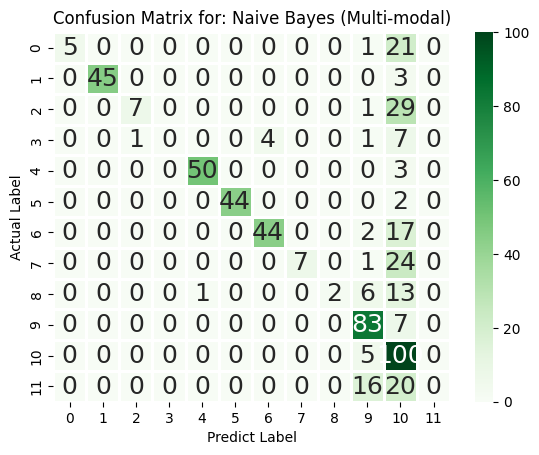

{0: 0.5925925925925926,
 1: 0.96875,
 2: 0.5936600151553423,
 3: 0.5,
 4: 0.9707347220707456,
 5: 0.9782608695652174,
 6: 0.8452770761218698,
 7: 0.609375,
 8: 0.5454545454545454,
 9: 0.9268787459658829,
 10: 0.8198735597022535,
 11: 0.5}

In [42]:
print_model_report(y_test, pred_nb_mm, "Naive Bayes (Multi-modal)")
plot_confusion_matrix(y_test, pred_nb_mm, "Naive Bayes (Multi-modal)", plt.cm.Greens)
roc_auc_score_multiclass(y_test, pred_nb_mm)

## Aggregate results

[0] Competencies: 27
[1] Consultant Profile: 48
[2] Initial & Target Situation: 37
[3] Initial Situation: 13
[4] Offer Title: 53
[5] Project Calculation: 46
[6] Reference Details: 63
[7] Reference Overview: 32
[8] Target Situation: 22
[9] Working Package Description: 90
[10] Working Package Examples: 105
[11] Working Package Overview: 36


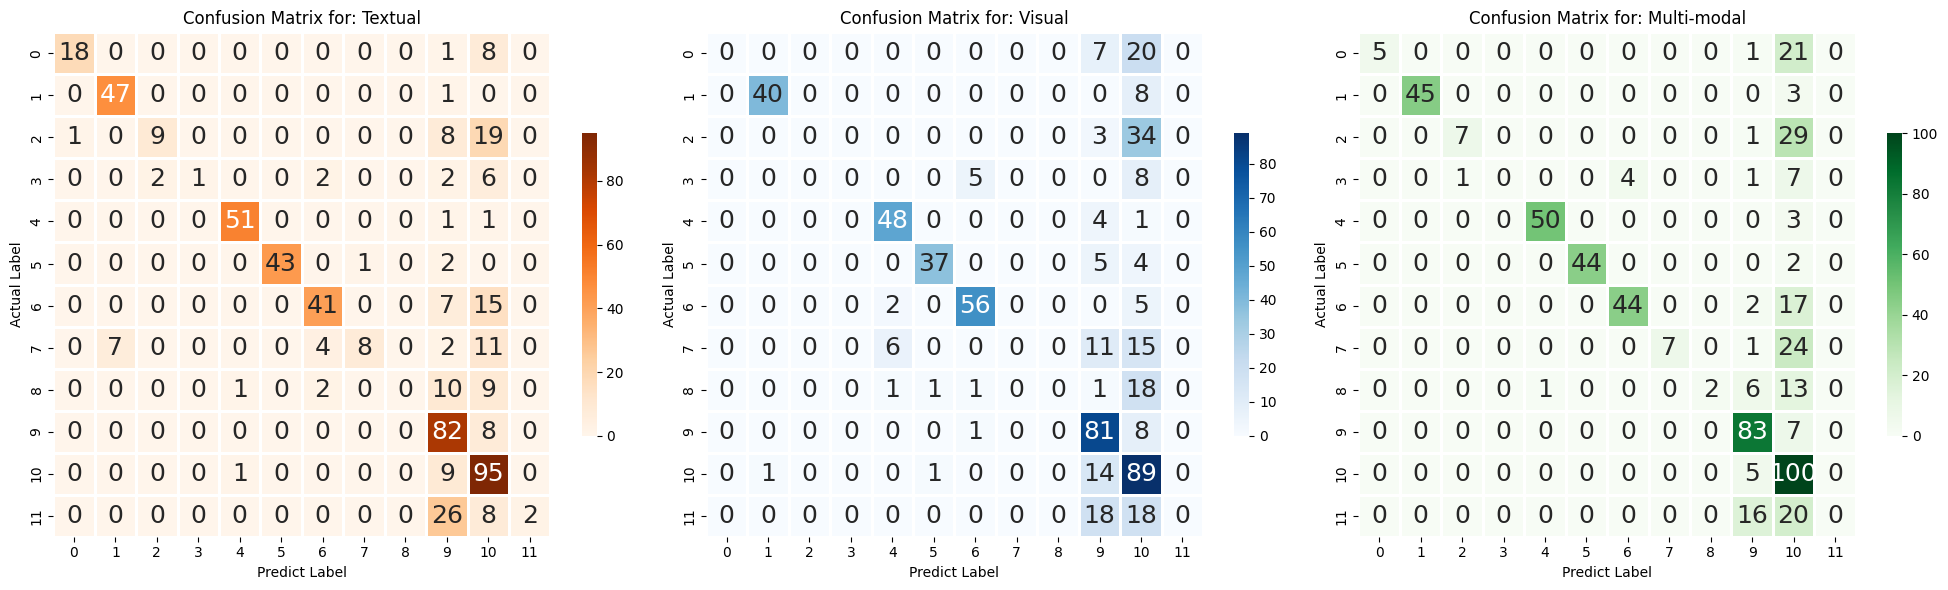

In [43]:
def plot_confusion_matrices(y_test, predictions, model_names, cmap):
    combined_cm = []
    for i, prediction in enumerate(predictions):
        cm = confusion_matrix(y_test, prediction)
        combined_cm.append(cm)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

    for i, ax in enumerate(axs.flat):
        sns.heatmap(combined_cm[i], 
                    annot=True, 
                    annot_kws={'size':18,'weight':'normal'},
                    fmt='.20g', 
                    cmap=cmap[i], 
                    cbar_kws={'shrink':0.6},
                    linewidths=2,
                    ax=ax)
        ax.set_title("Confusion Matrix for: " + model_names[i])
        ax.set_ylabel("Actual Label")
        ax.set_xlabel("Predict Label")
    fig.tight_layout()
    plt.show()


models = ["Textual", "Visual", "Multi-modal"]
preds = [pred_nb_t, pred_nb_v, pred_nb_mm]
colors = [plt.cm.Oranges, plt.cm.Blues, plt.cm.Greens]

labels_name = ['Competencies', 
               'Consultant Profile', 
               'Initial & Target Situation', 
               'Initial Situation', 
               'Offer Title', 
               'Project Calculation', 
               'Reference Details', 
               'Reference Overview',
               'Target Situation',
               'Working Package Description',
               'Working Package Examples',
               'Working Package Overview']

for i, label in enumerate(labels_name):
    num = y_test.value_counts().sort_index()
    print(f"[{i}] {label}: {num[i]}")

plot_confusion_matrices(y_test, preds, models, colors)

> Confusion Matrix for three approach types (Textual, Visual, Multi-Modal) reveals suboptimal model performance due to imbalanced testing data in the following categories: **Competencies[0]**, **Initial & Target Situation[2]**, **Initial Situation[3]**, **Reference Overview[7]**, **Target Situation[8]**, **Working Package Overview[11]**. To address this issue, we should adjust the distribution of label data and retrain the model.

> Imbalance may affect model exhibit a bias towards predicting class more frequently, it has more examples to learn from majority labels and may struggle to accurately capture the patterns in other minor labels.

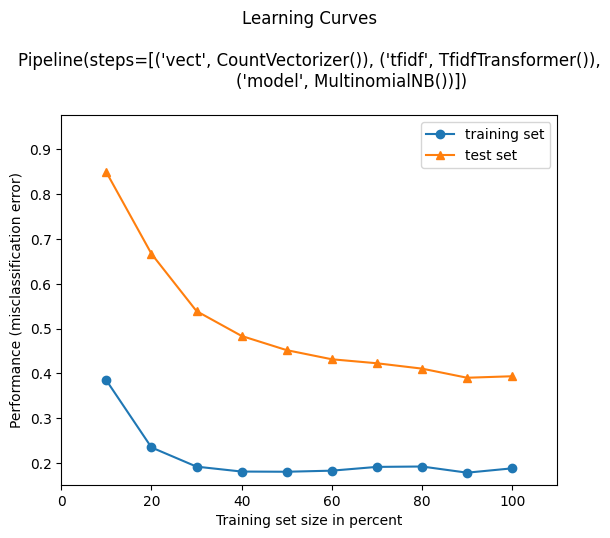

In [106]:
from mlxtend.plotting import plot_learning_curves

plot_learning_curves(train['Document'], train.Class, test['Document'], test.Class, model_nb_t, print_model=True,)
plt.show()